<a href="https://colab.research.google.com/github/romenlaw/ML-playground/blob/main/ml_playground2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Some functions to plot our points and draw the lines
def plot_points(features, labels):
  X = np.array(features)
  y = np.array(labels)
  spam = X[np.argwhere(y==1)]
  ham = X[np.argwhere(y==0)]
  plt.scatter([s[0][0] for s in spam],
              [s[0][1] for s in spam],
              s = 100,
              color = 'cyan',
              edgecolor = 'k',
              marker = '^')
  plt.scatter([s[0][0] for s in ham],
              [s[0][1] for s in ham],
              s = 100,
              color = 'red',
              edgecolor = 'k',
              marker = 's')
  plt.xlabel('aack')
  plt.ylabel('beep')
  plt.legend(['happy','sad'])

def draw_line(a,b,c, starting=0, ending=3, **kwargs):
  # Plotting the line ax + by + c = 0
  x = np.linspace(starting, ending, 1000)
  plt.plot(x, -c/b - a*x/b, **kwargs)

# Classification

Regression models predict a number; whereas *classification* models predict a state or a category (drawing a line to separate our data points).

*Perceptron* uses linear regression and is building block of neuro net.

Instead of expressing a line with $y=mx+b$, we rewrite it into $w_1x_1+w_2x_2+b=0$
The line divides the plane into two zones with LHS>=0 being the positive zone, LHS<0 the negative zone.

If we want to flip the positive and negative zones, simplly change the sign of all the w and b in the equation.

Step function (a specific case of activation function):
* $step(x)=1 \text{ if } x\ge 0 $
* $step(x)=0 \text{ if } x\lt 0 $

The perceptron can be expressed with step function - the perceptron produces 1 if point is in positive zone; 0 if in negative zone:
$$\hat{y}=step(w_1x_1+w_2x_2+b)$$

The bias / intercept term basically gives the result for when w's are 0. i.e. in the alien sentiment example, it's the sentiment of a quiet alien (no words are said).

## Error function

Intuitively, we can sum up the distance of wrongly classified points and the dividing line. But this is not used because it's complicated to calculate the distance: the square root has complicated derivative.

So instead we use a *score* with these properties:
1. points on boundary, score=0
2. points in +zone, score>0
3. points in -zone, score<0
4. points close to boundary, |score| is small
5. points far from boundary, |score| is large

The *perceptron error* should be proportional to the distance between point and boundary. The perceptron for a point is defined as:
1. if point is correctly classified, error=0
2. if point is misclassified, $\text{error}=|w_1x_1+w_2x_2+\ldots+w_nx_n+b|=| w\cdotp x + b |$

The derivitives of the error:
* $\frac{\delta \text{error}}{\delta w}=x$
* $\frac{\delta \text{error}}{\delta b}=1$

The *mean perceptron error* (i.e. the error for entire dataset) = average of perceptron errors of all points.

## Perceptron Algorithm

Using the happy/sad alien as an example. They have two words (Ha, Boo) in their vocab (i.e. features is 2-dim).

   Ha  Boo  Happy(1)/Sad(0)
0   1    0                0
1   0    2                0
2   1    1                0
3   1    2                0
4   1    3                1
5   2    2                1
6   2    3                1
7   3    2                1


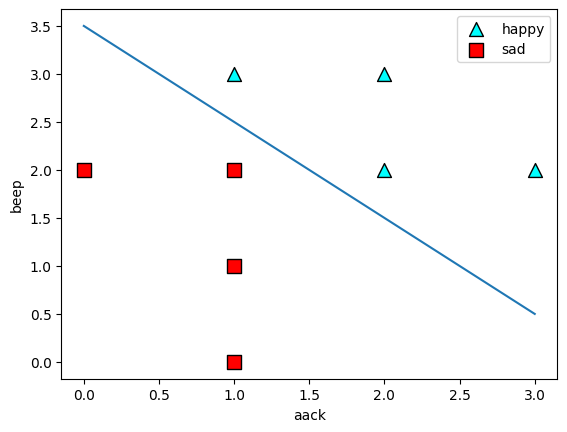

In [4]:
# we have 8 data points and their labels in the dataset
features = np.array([[1,0],[0,2],[1,1],[1,2],[1,3],[2,2],[2,3],[3,2]])
labels = np.array([0,0,0,0,1,1,1,1])

# printing the dataset in table
df = pd.DataFrame({
    'Ha' : features[:,0],
    'Boo' : features[:,1],
    'Happy(1)/Sad(0)': labels
})
print(df)

# Plotting the points
plot_points(features, labels)

# Uncomment the following line to see a good line fit for this data.
draw_line(1,1,-3.5)

In [ ]:
def step(x):
  return 1 if x>=0 else 0

def score(weights, bias, features):
  return np.dot(features, weights) + bias

def prediction(weights, bias, features):
  return step(score(weights, bias, features))

def error(weights, bias, features, label):
  pred = prediction(weights, bias, features)
  if pred == label:
    return 0
  else:
    return np.abs(score(weights, bias, features))


